In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.
/Users/thomascurran/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
test = pd.read_csv("/Users/thomascurran/desktop/MACS30200proj2/Data/ms_test2.csv").drop("Unnamed: 0", axis = 1)

In [23]:
test['Year'] = test['Year'].astype('category')

In [24]:
test2 = test.select_dtypes(include = ['int', 'float'])

In [25]:
y = test2['IndexScore']
x = test2.iloc[:,1:len(test2)]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, train_size = .76, random_state = 25)

In [26]:
xtrain = xtrain.values
xtest = xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [27]:
def kfold_cv(func, k = 4, epochs = 10, batch = 1):
    all_mae_histories = []
    all_mse_histories = []
    num_val_samples = len(xtrain)//k
    
    
    for i in range(0,k):
        print('processing fold #', i)
        
        val_data = xtrain[i * num_val_samples: (i + 1) * num_val_samples]    
        
        val_targets = ytrain[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(                                     
            [xtrain[:i * num_val_samples],
             xtrain[(i + 1) * num_val_samples:]],
            axis=0)
        
        partial_train_targets = np.concatenate(
            [ytrain[:i * num_val_samples],
             ytrain[(i + 1) * num_val_samples:]],
            axis=0)

        model = func()                                                    
       
        history = model.fit(partial_train_data, 
                            partial_train_targets,           
                            validation_data=(val_data, val_targets),
                            epochs=epochs, 
                            batch_size=batch, 
                            verbose=0)
        
        mae_history = history.history['val_mean_absolute_error']
        all_mae_histories.append(mae_history)
       
        mse_history = history.history['val_loss']
        all_mse_histories.append(mse_history)
        
    return(all_mae_histories, 
               all_mse_histories, 
               xtrain,
               ytrain,
               model, 
               history)

In [28]:
#Produces the MAE plot for each model
def mae_plot(mses, epochs):
    avg_mae = [np.mean([x[i] for x in mses]) for i in range(epochs)]
    plt.figure(figsize = (10,10))
    plt.plot(range(1, len(avg_mae) + 1), avg_mae)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MSE')
    plt.show()

In [29]:

#prints the MSE and MAE for each Model#prints t 
def model_metrics(test_data, test_targets, model):
    mse, mae = model.evaluate(test_data, test_targets)
    print("MSE For Test Set: ", mse)
    print("MAE For Test Set: ", mae)

In [30]:
#function that passes in the data to all the other functions
def q3(model, k=10, epochs = 10, batch = 1):
    mae_scores, mse_scores, test_data, test_targets, model_train, model_history = kfold_cv(model, k, epochs, batch)
    mae_plot(mse_scores, epochs)
    model_metrics(test_data, test_targets, model_train)
    return(mae_scores, mse_scores)

In [31]:
from keras import regularizers

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


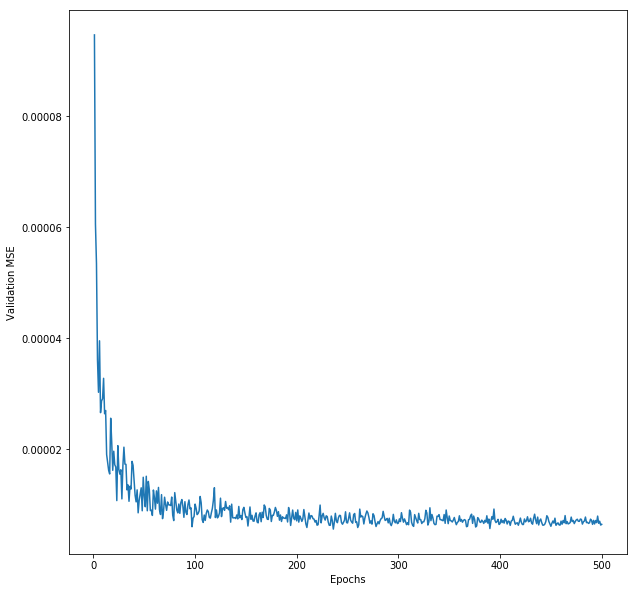

675/675 [==============================] - 0s 38us/step
MSE For Test Set:  1.54375421104e-06
MAE For Test Set:  0.000884831470558


In [32]:
K = 10
epochs = 500
batch = 50

def baseline():
    model = models.Sequential()
    
    model.add(layers.Dense(64, 
                           activation='relu',
                           input_shape=(xtrain.shape[1],)))
    
    model.add(layers.Dense(64, 
                           activation='relu'))
    
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', 
                  loss='mse', 
                  metrics=['mae'])
    return model

baseline_mae, baseline_mses = q3(baseline, K, epochs, batch)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


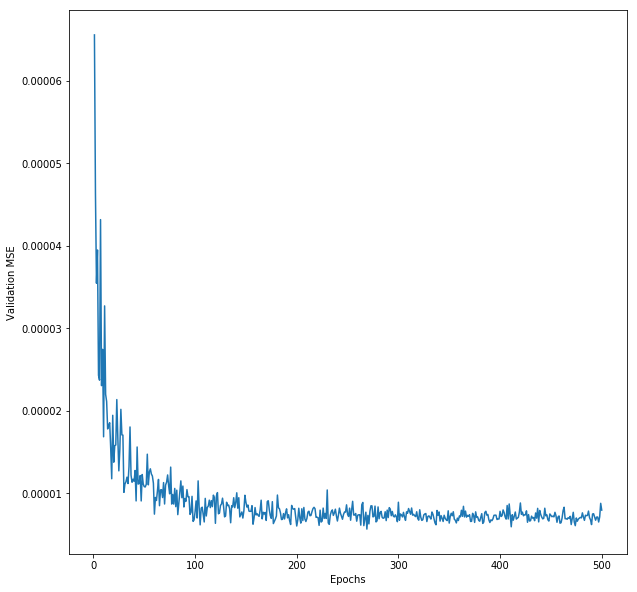

675/675 [==============================] - 0s 30us/step
MSE For Test Set:  2.10299658294e-06
MAE For Test Set:  0.00109086103453


In [33]:
#Model 2
'''
Changing:

First layer input to 100
K = 10 (as instructed)

changing model to dropout layer

changing batch size to 50

'''
K = 10
epochs = 500
batch = 50
def model2():
    model = models.Sequential()
    
    model.add(layers.Dense(100, activation='relu',
                           input_shape=(xtrain.shape[1],)))
    model.add(layers.Dropout(.5))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(.5))

    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

model2_mae, model2_mses = q3(baseline, K,epochs, batch)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


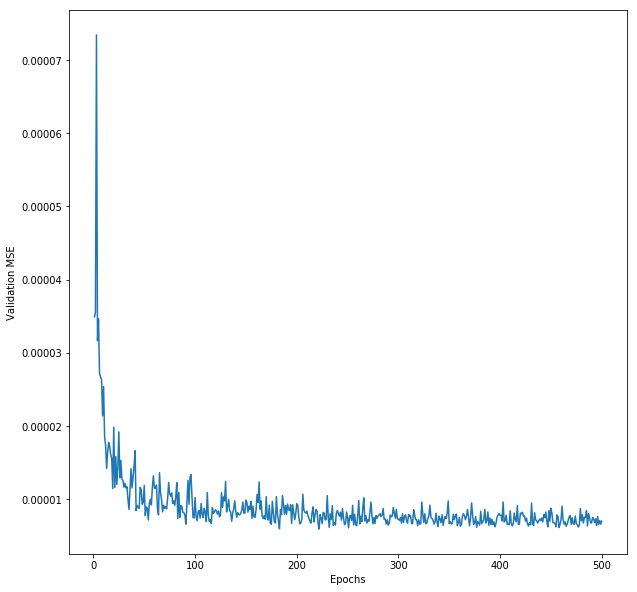

675/675 [==============================] - 0s 42us/step
MSE For Test Set:  1.33906630313e-06
MAE For Test Set:  0.000818853836326


In [34]:
#Model 3
'''
Changing:

adding more layers w/o dropout, keeping k, epochs and batch the same

K = 10
epochs = 200
batch = 150

'''
K = 10
epochs = 500
batch = 50

def model4():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu',
                           input_shape=(xtrain.shape[1],)))
    model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model3_mae, model3_mses = q3(model4,K,epochs, batch)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


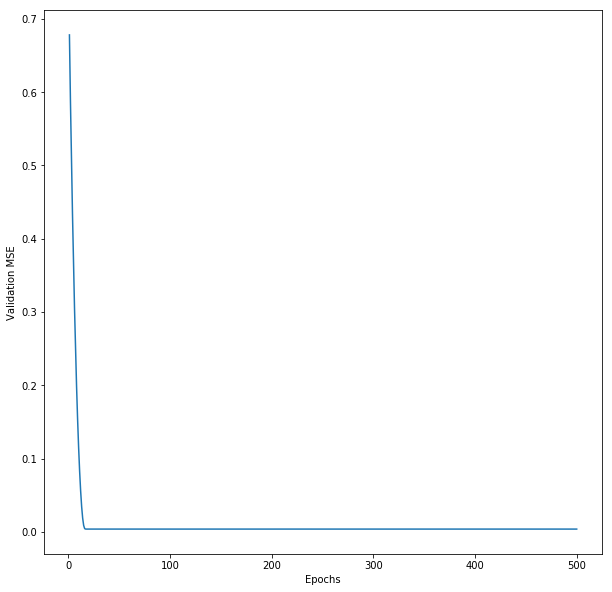

675/675 [==============================] - 0s 62us/step
MSE For Test Set:  0.00373192895721
MAE For Test Set:  0.00433100503421


In [41]:
#Model 5
'''
Changing:

returning to base model but changing to l1 penalization
K = 10
epochs = 200
batch = 150

kernel_regularizer = regularizers.l1(0.001)
'''
K = 10
epochs = 500
batch = 50

def model5():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(64, activation='relu',
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model5_mae, model5_mses = q3(model5,K,epochs, batch)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


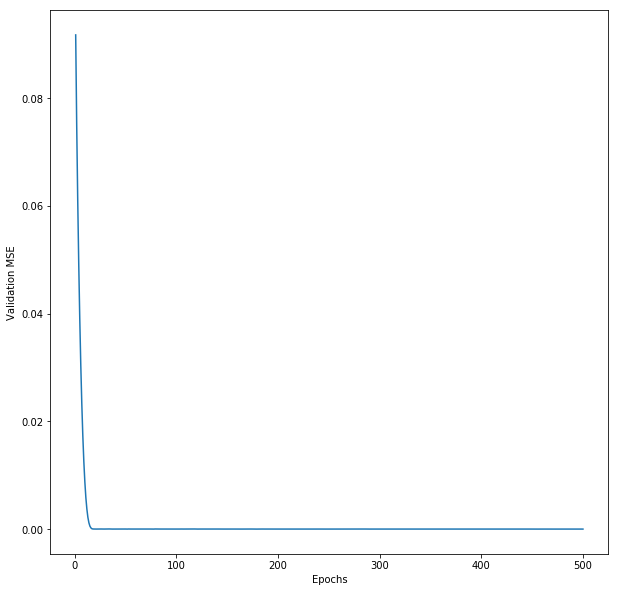

675/675 [==============================] - 0s 39us/step
MSE For Test Set:  3.37598051394e-05
MAE For Test Set:  0.00431410211656


In [36]:
'''
Changing:

returning to base model but changing to l2 penalization

kernel_regularizer = regularizers.l2(0.001)
'''
K = 10
epochs = 500
batch = 50

def model6():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(64, activation='relu',
                          kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model6_mae, model6_mses = q3(model6,K,epochs, batch)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


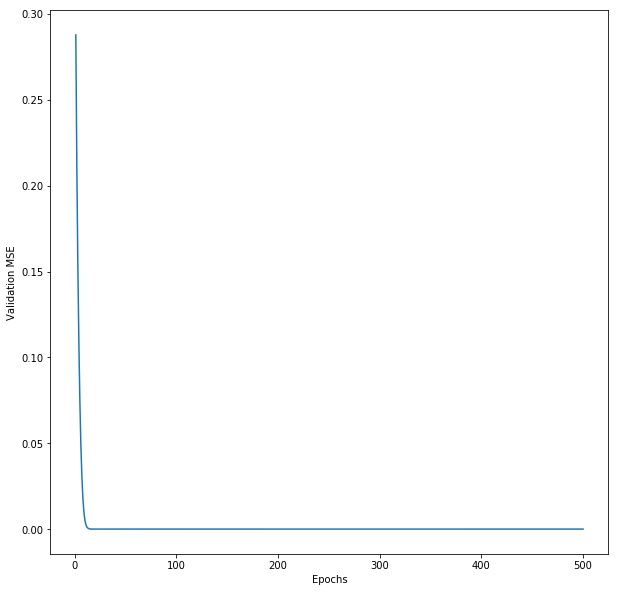

675/675 [==============================] - 0s 56us/step
MSE For Test Set:  4.32850455346e-05
MAE For Test Set:  0.00430238519485


In [37]:
'''
Changing:

since model 3 had some good performance, I am going to add a l2 penalization
since model 5 worked well


'''
K = 10
epochs = 500
batch = 50

def model7():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu', input_shape=(xtrain.shape[1],),kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(150, activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(100, activation='relu',kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(50, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model7_mae, model7_mses = q3(model7,K,epochs, batch)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


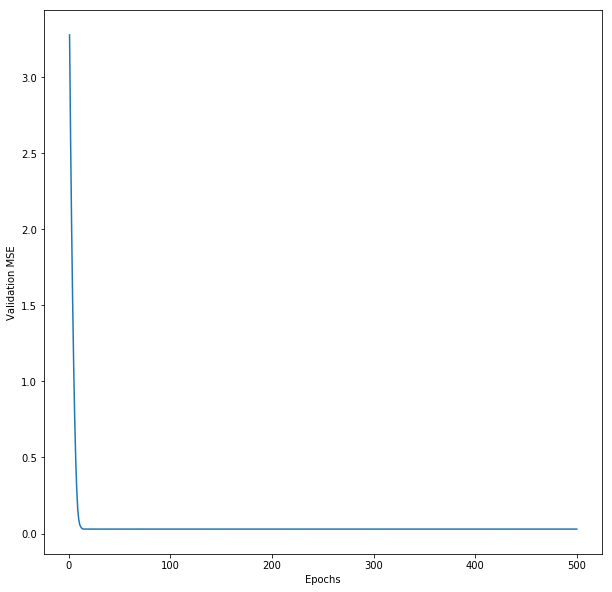

675/675 [==============================] - 0s 54us/step
MSE For Test Set:  0.0291849687171
MAE For Test Set:  0.0043380646856


In [38]:
'''
Changing:

Seeing if anything changes with l1 penalization


'''
K = 10
epochs = 500
batch = 50

def model8():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu', input_shape=(xtrain.shape[1],),kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(150, activation='relu',kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(100, activation='relu',kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(50, activation='relu', kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model8_mae, model8_mses = q3(model8,K,epochs, batch)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


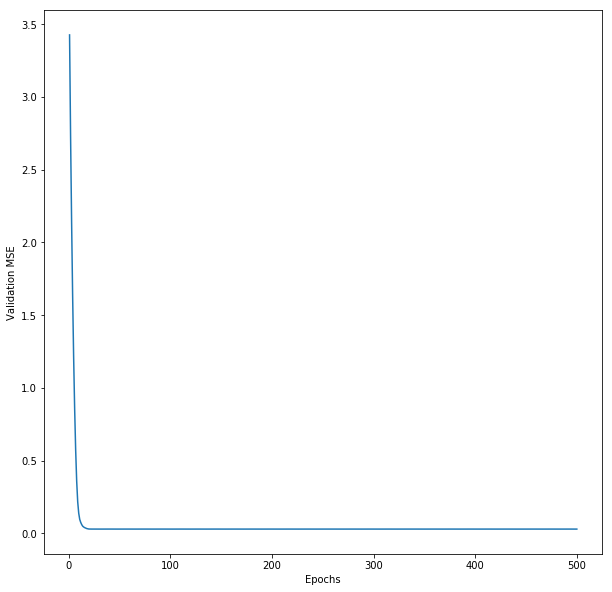

675/675 [==============================] - 0s 66us/step
MSE For Test Set:  0.0296526554172
MAE For Test Set:  0.0053061035241


In [39]:
#Model 8
'''
Changing:

returning to base model but changing to l1 penalization
K = 10
epochs = 200
batch = 150

kernel_regularizer = regularizers.l1(0.001)
'''
K = 10
epochs = 500
batch = 50

def model9():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(150, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(100, activation='relu',
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(50, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(25, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l1(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model9_mae, model9_mses = q3(model9,K,epochs, batch)

In [40]:
'''
Changing:

returning to base model but changing to l2 penalization

kernel_regularizer = regularizers.l2(0.001)

K = 10
epochs = 500
batch = 50

def model6():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(100, activation='relu',
                          kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

model6_mae, model6_mses = q3(model6,K,epochs, batch)
'''
def model_final():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(xtrain.shape[1],),
                          kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(64, activation='relu',
                          kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#model6_mae, model6_mses = q3(model6,K,epochs, batch)

model = model_final()

model_fit = model.fit(xtrain, ytrain, epochs = 100, batch_size = 10, verbose = 0)

model_eval = model.evaluate(xtest, ytest)

print(model_eval)

214/214 [==============================] - 1s 3ms/step
[2.8603309070502156e-05, 0.0040858667648493129]
